In [104]:
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [147]:
# file containing indexs of close (< 10km) row indexes from WAMEX from .SHP file containing Nickel Drillhold deposits
# NOTE: rows are repeated!
with open('../eli/wamex_close_coords_to_shp_minedex_terminatedafter12hrs.pickle', 'rb') as file:
    close_coords_indicies = pickle.load(file)

### Subset of Close Coords

In [148]:
# repeats indexes so set to find unique row indexs
close_coords_indicies = list(set(close_coords_indicies))
print(f"\n Sample: {close_coords_indicies[:10]} \n\n Length: {len(close_coords_indicies)}")


 Sample: [131072, 131073, 131084, 131085, 131086, 131087, 131088, 131089, 131090, 131091] 

 Length: 75628


### WAMEX data

 ·      Cobalt associated with nickel (and copper) in so-called orthomagmatic (igneous) mafic to ultramafic volcanic (komatiite)-hosted and intrusion-hosted deposits
 
 
 Cobalt is a chemical element with the symbol Co and atomic number 27. Like nickel, cobalt is found in the Earth's crust only in a chemically combined form, save for small deposits found in alloys of natural meteoric iron. The free element, produced by reductive smelting, is a hard, lustrous, silver-gray metal. Wikipedia
Symbol: Co <br>
Electron configuration: [Ar] 3d74s2 <br>
Atomic number: 27 <br>
Atomic mass: 58.933195 u <br>
Melting point: 1,495 °C <br>
Discovered: 1735 <br>
Discoverer: Georg Brandt <br>

In [157]:
df_wamex_rc = pd.read_csv('../data/wamex/WAMEX_1_Rockchip_Original.csv')
df_wamex_rc.head(2)

C:\Users\elisi\Miniconda3\envs\minerals\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,OBJECTID,DATASET,SAMPLEID,GSWANO,EXTRACT_DA,BATCH_NO,QMAPID,DLAT,DLONG,EASTING,...,W_ppm,WO3_ppm,Y_ppm,Y2O3_ppm,Yb_ppm,Yb2O3_ppm,Zn_ppm,ZnO_ppm,Zr_ppm,ZrO2_ppm
0,1,NaN,229866,NaN,NaN,NaN,NaN,-34.048839,118.176663,NaN,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1,2,NaN,229867,NaN,NaN,NaN,NaN,-34.048839,118.176663,NaN,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [158]:
df_wamex_rc.shape

(402770, 143)

In [156]:
x.shape

(98655, 143)

In [150]:
df_wamex_rc = df_wamex_rc.iloc[close_coords_indicies,:]
df_wamex_rc.shape

(75628, 143)

In [ ]:
df_wamex_less_than_10km_subset

In [11]:
df_wamex_rc.columnsumns

Index(['OBJECTID', 'DATASET', 'SAMPLEID', 'GSWANO', 'EXTRACT_DA', 'BATCH_NO',
       'QMAPID', 'DLAT', 'DLONG', 'EASTING',
       ...
       'W_ppm', 'WO3_ppm', 'Y_ppm', 'Y2O3_ppm', 'Yb_ppm', 'Yb2O3_ppm',
       'Zn_ppm', 'ZnO_ppm', 'Zr_ppm', 'ZrO2_ppm'],
      dtype='object', length=143)

### Nickel, Copper and Cobalt Interactions

In [211]:
# most common pair in MINEDEX data.
abdundant_minerals = ['Copper', 'Nickel', 'Iron', 'Gold', 'Silver'] #'Sulfur', 'Palladium','Platinum',
critical_mineral = ['Cobalt']

full_to_atomic = {
    "Copper": "Cu",
    "Cobalt": "Co",
    "Nickel": "Ni",
    "Iron": "Fe",
    "Sulfur": "S",
    "Palladium": "Pd",
    "Platinum": "Pt",
    "Gold": "Au",
    "Silver": "Ag"
}


In [212]:
new_cols = []
for col in df_wamex_rc.columns: 
    if "ppm" in col:
        new_cols.append(col.split('_')[0])
    else:
        new_cols.append(col)

df_wamex_rc.columns = new_cols

In [213]:
minerals = abdundant_minerals + critical_mineral

minerals_atomic = [full_to_atomic[mineral] for mineral in minerals]
minerals_atomic

['Cu', 'Ni', 'Fe', 'Au', 'Ag', 'Co']

In [214]:
input_cols = ['DLAT', 'DLONG'] + minerals_atomic

In [215]:
df = df_wamex_rc[input_cols]
df.head(5)

,DLAT,DLONG,Cu,Ni,Fe,Au,Ag,Co
0,-34.048839,118.176663,252.0,-9999.0,-9999.0,0.008,-9999.0,-9999.0
1,-34.048839,118.176663,447.0,-9999.0,-9999.0,0.012,-9999.0,-9999.0
2,-34.048839,118.176663,314.0,-9999.0,-9999.0,0.005,-9999.0,-9999.0
3,-34.048839,118.176663,115.0,-9999.0,-9999.0,0.005,-9999.0,-9999.0
4,-34.048839,118.176663,11.0,-9999.0,-9999.0,0.009,-9999.0,-9999.0


In [216]:
def replace_neg9999(val):
    if val == -9999: 
        return 0
    else:
        return val
    
    
def abs_halve_neg_val(val):
#     print(val)
    if val < 0: 
        return abs(val) / 2
    else: 
        return val

df = df.applymap(replace_neg9999)
df = df.applymap(abs_halve_neg_val)

indexs_6666 = df[df.values == -6666].index
df = df.drop(index=indexs_6666)

indexs_0 = df[df.values == 0].index
df = df.drop(index=indexs_0)

In [217]:
df.head(2)

,DLAT,DLONG,Cu,Ni,Fe,Au,Ag,Co
136,8.871268,127.903385,65.0,182.2,4930.0,0.001,0.05,64.0
137,8.868529,127.903390,77.3,247.2,5600.0,0.001,0.05,62.0


<AxesSubplot:ylabel='Frequency'>

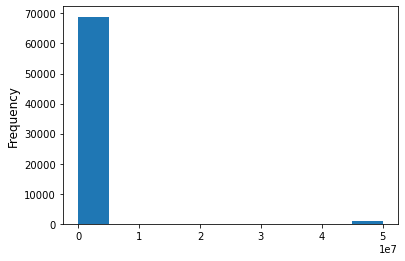

In [218]:
df['Co'].plot(kind='hist')

#### Cobalt ppm < 100

<AxesSubplot:ylabel='Frequency'>

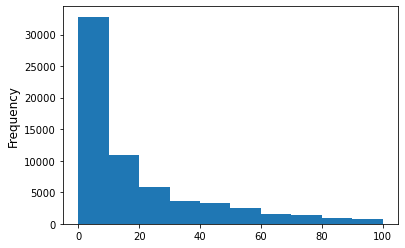

In [219]:
df = df[df['Co'] < 100]

df['Co'].plot(kind='hist')

### Independent Variables

In [220]:
from sklearn.preprocessing import StandardScaler

<AxesSubplot:>

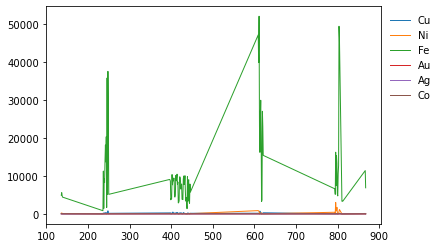

In [221]:
df[minerals_atomic][:100].plot()

In [222]:
df = df.reset_index(drop=True)
# df = df.drop(columns=['index'])
df.head()

,DLAT,DLONG,Cu,Ni,Fe,Au,Ag,Co
0,8.871268,127.903385,65.0,182.2,4930.0,0.0010,0.05,64.0
1,8.868529,127.903390,77.3,247.2,5600.0,0.0010,0.05,62.0
2,8.868982,127.903422,60.9,179.6,4810.0,0.0010,0.05,40.0
3,8.867164,127.903425,21.7,97.6,4420.0,0.0010,0.05,45.0
4,11.260281,117.686979,56.0,23.0,850.0,0.1828,0.10,4.0


In [223]:
df.shape

(63452, 8)

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyrolite.plot import pyroplot
from pyrolite.plot.density import density
from pyrolite.comp.codata import close

In [225]:
df_minerals_log = df[minerals_atomic].apply(lambda x: np.log(x), axis=1)

C:\Users\elisi\Miniconda3\envs\minerals\lib\site-packages\mpltern\ternary\transforms.py:207: RuntimeWarning: divide by zero encountered in true_divide
  points /= np.sum(points, axis=1)[:, np.newaxis]
C:\Users\elisi\Miniconda3\envs\minerals\lib\site-packages\mpltern\ternary\transforms.py:207: RuntimeWarning: invalid value encountered in true_divide
  points /= np.sum(points, axis=1)[:, np.newaxis]


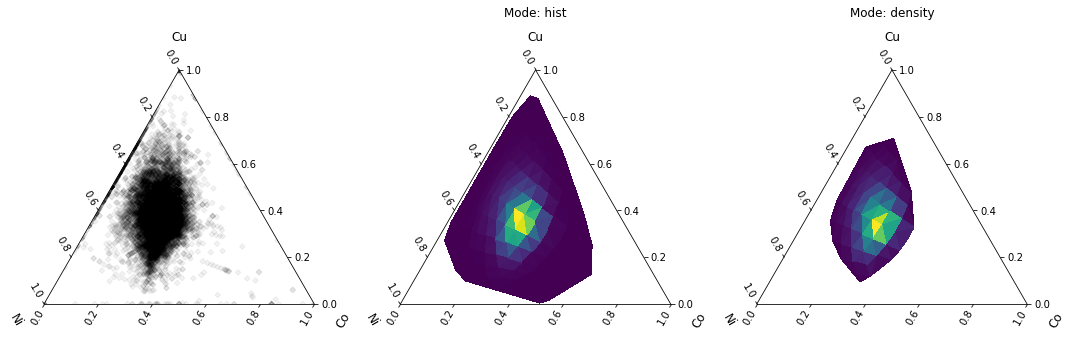

In [97]:
fig, ax = plt.subplots(
    1,
    3,
    sharex=True,
    sharey=True,
    figsize=(15, 5),
    subplot_kw=dict(projection="ternary"),
)
df_minerals_log.pyroplot.scatter(ax=ax[0], alpha=0.05, c="k")
for a, mode in zip(ax[1:], ["hist", "density"]):
    df_minerals_log.pyroplot.density(ax=a, mode=mode)
    a.set_title("Mode: {}".format(mode), y=1.2)

plt.tight_layout()
plt.show()

In [226]:
y = df['Co']
X = df.drop(columns=['Co'])

In [227]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

lr = LinearRegression()

lr.fit(X_train, y_train)
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

from sklearn.metrics import mean_squared_error

print(f"Train MSE: {mean_squared_error(train_preds, y_train)}")
print(f"Test MSE: {mean_squared_error(test_preds, y_test)}")

Train MSE: 443.77654255156796
Test MSE: 440.1694454861714


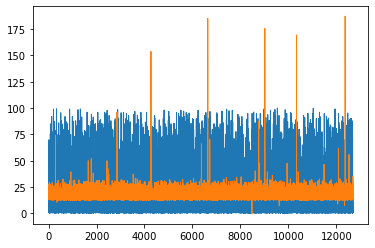

In [228]:
plt.plot(range(0, len(test_preds)), y_test, test_preds)

#### Random Forrest

In [229]:
rf = RandomForestRegressor(n_estimators=50, min_samples_leaf=5)

rf.fit(X_train, y_train)
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

print(f"Train MSE: {mean_squared_error(train_preds, y_train)}")
print(f"Test MSE: {mean_squared_error(test_preds, y_test)}")

Train MSE: 54.22884606319288
Test MSE: 113.68339990649483


In [201]:
pd.Series(X_train.columns,rf.feature_importances_)

0.111144     DLAT
0.096267    DLONG
0.094395       Cu
0.698194       Ni
dtype: object